In [1]:
import pandas as pd
import numpy as np
import csv
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
from sklearn.linear_model import LinearRegression

In [2]:
p_info = pd.read_csv('participants_data.csv')

In [3]:
summary = pd.DataFrame()
fatigue = pd.DataFrame()
for i, row in p_info.iterrows():
    if row['pid'] in []:
        continue
        
    fatigue_data = pd.read_csv('result/' + row['pid'] + '_fatigue.csv', index_col=0)
    condition_data = pd.read_csv('result/' + row['pid'] + '_' + row['condition'] + '_training.csv', index_col=0)
    ERD_list = []
    ERD_per_list = []
    for day, block in itertools.product(['Day1', 'Day2', 'Day3'], range(5)):
        if row['condition'] == 'continuous':
            file_index = 'FB'
        else:
            file_index = row['condition']
        filename = 'result/' + row['pid'] + '_' + file_index + '_ERSP_' + day + '_b' + str(block) + '.csv'
        
        if os.path.exists(filename) == False:
            continue
        
        with open(filename, 'r') as f:
            data = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

        for FB in data:
            ERD_list.append(np.average(FB))
            ERD_per_list.append(sum(i < -10 for i in FB) / len(FB))
    condition_data['ERSP'] = ERD_list
    condition_data['Percent'] = ERD_per_list
    
    summary = pd.concat([summary, condition_data])
    fatigue = pd.concat([fatigue, fatigue_data])

In [4]:
fatigue = fatigue[(fatigue.pid != 'P10') | (fatigue.day != 'Day1')]

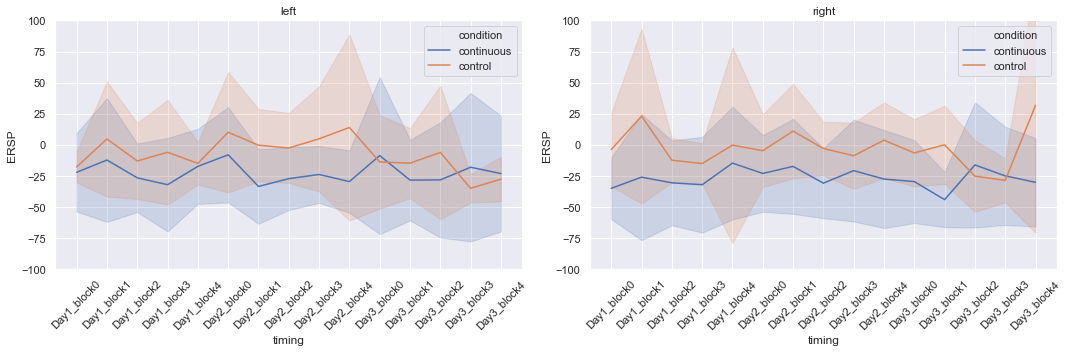

In [31]:
groupby_summary = summary.groupby(['pid', 'condition', 'day', 'block', 'hand'], sort=False, as_index=False).median()
groupby_summary['timing'] = groupby_summary['day'] + '_block' + [str(n) for n in groupby_summary['block'].values]
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='ERSP', hue='condition', ci='sd', data=groupby_summary[groupby_summary.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)
    plt.ylim(-100, 100)
plt.tight_layout()
plt.savefig('result_img/ERSP-variation.png')

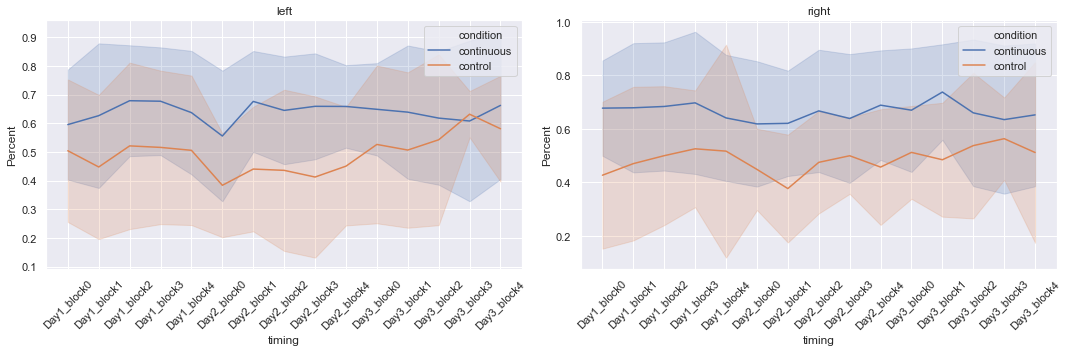

In [7]:
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='Percent', hue='condition', ci='sd', data=groupby_summary[groupby_summary.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('result_img/ratio-of-ERD.png')

In [8]:
fatigue['Percent'] = summary.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().Percent.values
fatigue['ERSP'] = summary.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().ERSP.values

In [9]:
lr_df = pd.DataFrame(columns=['pid', 'condition', 'factor', 'ERSP', 'Percent'])
model = LinearRegression()
for factor in ['difficulty', 'concentrate', 'fatigue', 'prediction']:
    for pid in p_info['pid']:
        df = fatigue[fatigue.pid == pid]
        if len(df) == 0:
            continue
        model.fit(df.loc[:, ['ERSP']].values, df.loc[:, [factor]].values)
        ERSP_coef = model.coef_.item()
        model.fit(df.loc[:, ['Percent']].values, df.loc[:, [factor]].values)
        Percent_coef = model.coef_.item()
        series = pd.Series([pid, p_info[p_info.pid == pid].condition.item(), factor, ERSP_coef, Percent_coef], index=lr_df.columns)
        lr_df = lr_df.append(series, ignore_index=True)

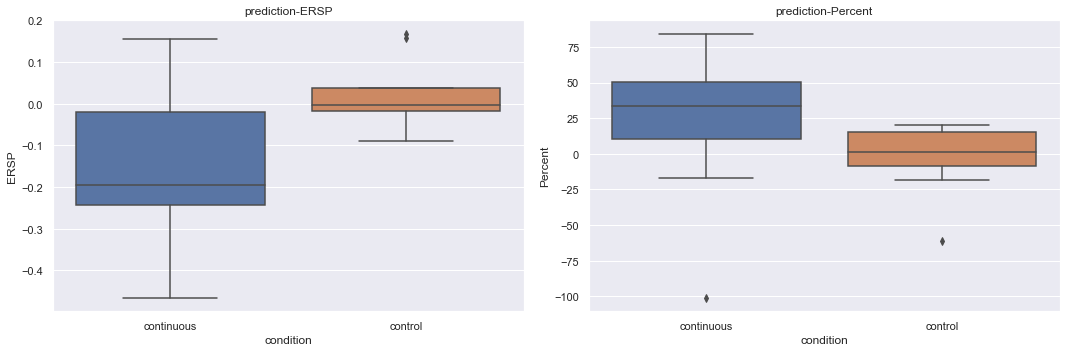

In [10]:
plt.figure(figsize=(15,5))
for i, value in enumerate(['ERSP', 'Percent']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='condition', y=value, data=lr_df[lr_df.factor == 'prediction'])
    plt.title(factor + '-' + value)
plt.tight_layout()
plt.savefig('result_img/corr_prediction-and-ERSP-Percent.png')

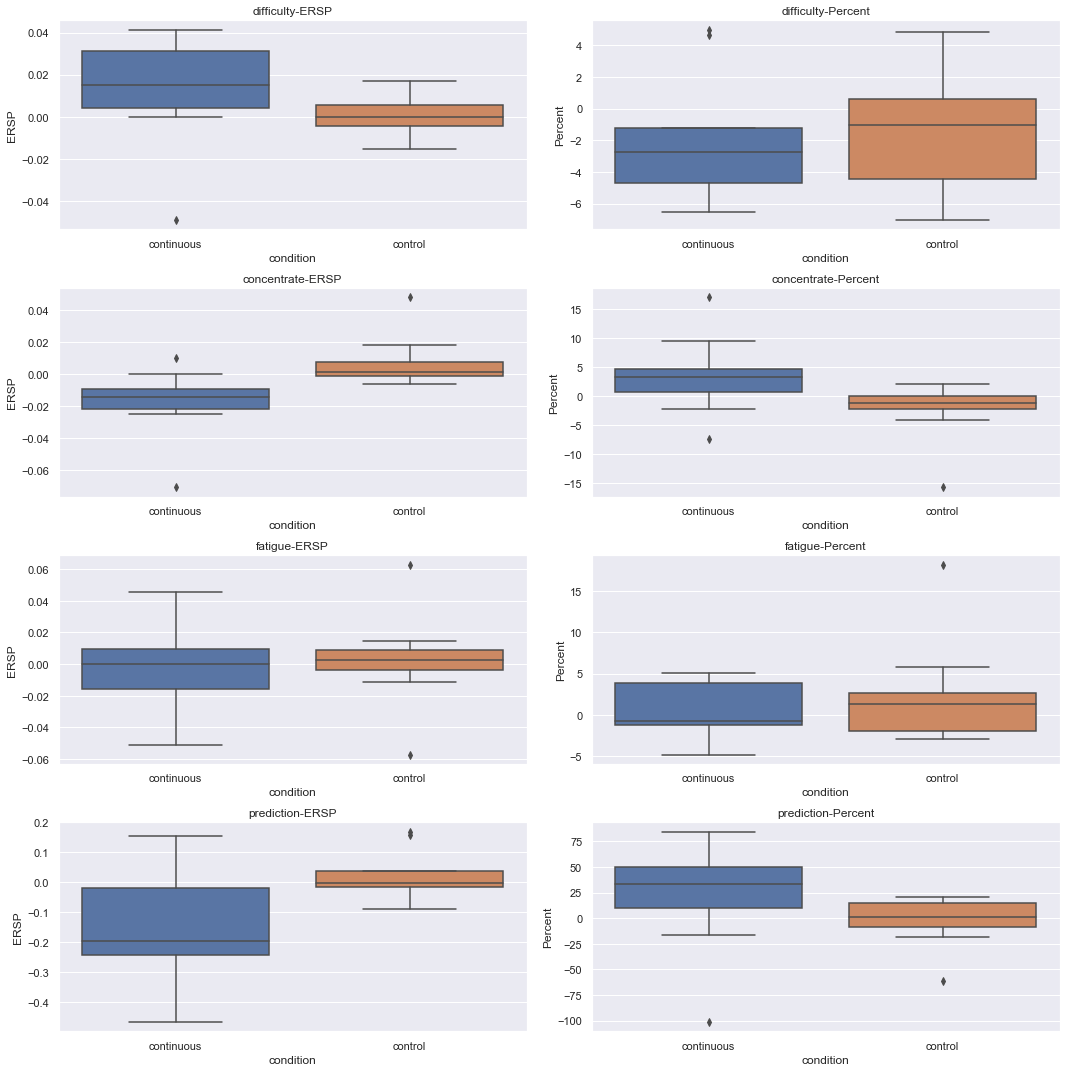

In [11]:
plt.figure(figsize=(15,15))
for i, (factor, value) in enumerate(itertools.product(['difficulty', 'concentrate', 'fatigue', 'prediction'], ['ERSP', 'Percent'])):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='condition', y=value, data=lr_df[lr_df.factor == factor])
    plt.title(factor + '-' + value)
plt.tight_layout()

In [25]:
pid = 'P12'
condition = p_info[p_info.pid == pid].condition.item()
fatigue_data = pd.read_csv('result/' + pid + '_fatigue.csv', index_col=0)
condition_data = pd.read_csv('result/' + pid + '_' + condition + '_training.csv', index_col=0)
ERD_list = []
ERD_per_list = []
for day, block in itertools.product(['Day1', 'Day2', 'Day3'], range(5)):
    if condition == 'continuous':
        file_index = 'FB'
    else:
        file_index = condition
    filename = 'result/' + pid + '_' + file_index + '_ERSP_' + day + '_b' + str(block) + '.csv'

    if os.path.exists(filename) == False:
        continue

    with open(filename, 'r') as f:
        data = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

    for FB in data:
        ERD_list.append(np.average(FB))
        ERD_per_list.append(sum(i < -10 for i in FB) / len(FB))
condition_data['ERSP'] = ERD_list
condition_data['Percent'] = ERD_per_list

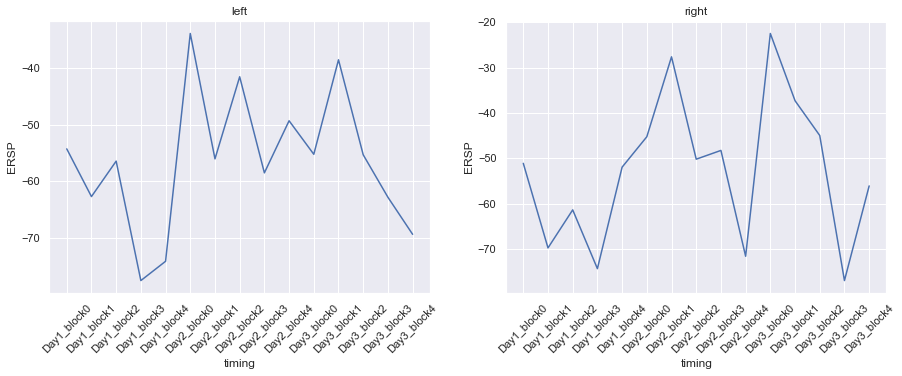

In [26]:
data = condition_data.groupby(['pid', 'condition', 'day', 'block', 'hand'], sort=False, as_index=False).median()
data['timing'] = data['day'] + '_block' + [str(n) for n in data['block'].values]
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='ERSP', data=data[data.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)

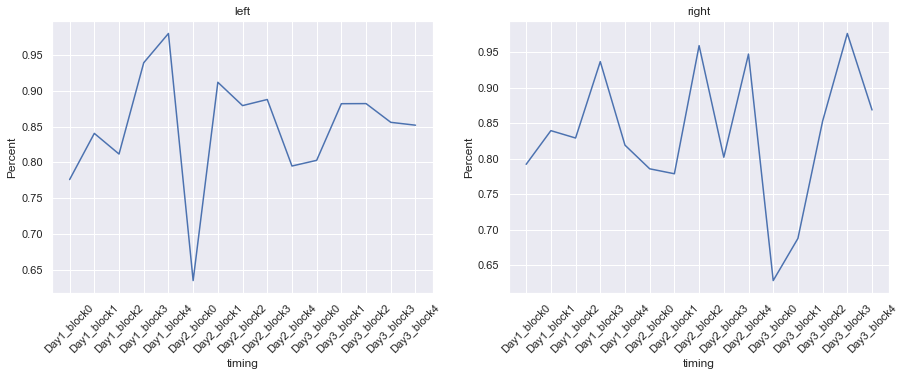

In [27]:
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='Percent', data=data[data.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)

In [28]:
fatigue_data['Percent'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().Percent.values
fatigue_data['ERSP'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().ERSP.values

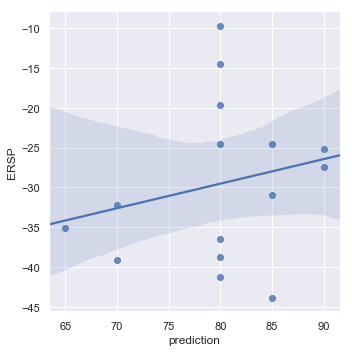

In [23]:
sns.lmplot(x='prediction', y='ERSP', data=fatigue_data)

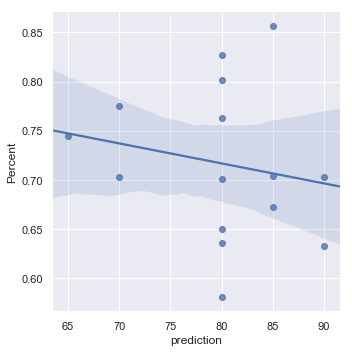

In [24]:
sns.lmplot(x='prediction', y='Percent', data=fatigue_data)